#### 분석방향 및 목적 : 타이타닉에 탑승한 사람들의 신상정보를 활용하여 승선한 사람들의 생존여부를 예측하는 모델을 생성할 것

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn') # matplotlib 테마 바꾸기. argument : default, dark_background, classic, ggplot, seaborn 등이 있음. 독립적으로 적용되는 것이 아니기 때문에 이전의 스타일이 겹쳐서 남아있을 수 있음.
sns.set(font_scale=2.5)  # 글씨 크기-> 축에 있는 라벨이나 제목 글씨 크기임. 차트 안에 들어있는 글씨들 크기 말고
# matplotlib의 기본 scheme 말고 seaborn scheme 세팅, 일일이 graph의 font size 지정할 필요없이 seaborn 의 font_scale 사용하면 편함.
# print(plt.style.available) 입력하면 가능한 스타일 종류가 모두 나온다.
# seaborn 미적 세팅. seaborn.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
import missingno as msno # 네비게이터로 안깔려서 cmd 로 깔았더니 됐다. 누락데이터 시각화

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os # 작업 디렉토리 관련된 모듈. 작업 경로, 경로 변경, 파일명 등

#### 대략적인 프로세서
1. 데이터확인 - 데이터 불러오기, 데이터 파악하기
2. EDA - 여러 feature들을 개별 분석, feature 간의 상관관계 확인. 여러 시각화툴 사용 insight 획득
3. feature engineering - 모델을 세우기 전 성능을 높일 수 있도록 engineering 수행. one-hot encoding, class 나누기, 구간으로 나누기, 텍스트 데이터 처리 등
4. 모델 만들기 - sklearn 을 사용해 모델 만들기. tensorflow, pytorch 도 가능
5. 모델 학습 및 예측 - train 적용 후 test 적용
6. 모델 평가 - 성능 수준이 원하는 수준인지 판단. 문제에 따라 평가 방식도 달라짐. 성능이 원하는 만큼 나오지 않을 경우 3번 단계부터 다시 진행

## Dataset 확인. 데이터 확인

In [2]:
# 데이터 불러오기 함수
df_train=pd.read_csv('./input/train.csv')
df_test=pd.read_csv('./input/test.csv') # /input 앞에 . 을 두개 쓰는건 뭐고 한개 쓰는건 뭔지
# csv 파일 형식을 불러들일 때 쓰는 함수. 다른 파일 형식에는 다른 함수를 사용하면 된다.

In [3]:
# 불러온 데이터 확인
df_train.head()
# df_train.tail() 이라는 함수도 있음. () 안에 숫자를 넣으면 원하는 개수만큼 데이터를 볼 수 있음.
# head() 는 위쪽 데이터 확인 tail() 은 아래쪽 데이터 확인 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 데이터 개수, 데이터 타입 등 정보 제공
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_test.info()
# 예측해야할 survival 제외되어있음.train 데이터셋과 test 데이터셋의 차이점 확인 필요.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
df_train.describe() # 숫자형 데이터 열만 통계치를 내주는 함수
# 데이터 수, 평균, 표준편차, 최대, 최소, 1,2,3 사분위수

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Null data Check 결측치 확인

In [8]:
# DataFrame.columns : The column labels of the DataFrame 데이터프레임의 모든 열 이름을 제공해준다.
for col in df_train.columns:
    msg='column: {:>10}\t Ratio of NaN value: {:.2f}%'.format(col, 
                                                              100*(df_train[col].isnull().sum()/df_train[col].shape[0]))
    print(msg)
# {:>10}\t , {:.2f%} .format 이런걸 정규표현식이라고 부르는데, 정규표현식은 공부가 필요함

column: PassengerId	 Ratio of NaN value: 0.00%
column:   Survived	 Ratio of NaN value: 0.00%
column:     Pclass	 Ratio of NaN value: 0.00%
column:       Name	 Ratio of NaN value: 0.00%
column:        Sex	 Ratio of NaN value: 0.00%
column:        Age	 Ratio of NaN value: 19.87%
column:      SibSp	 Ratio of NaN value: 0.00%
column:      Parch	 Ratio of NaN value: 0.00%
column:     Ticket	 Ratio of NaN value: 0.00%
column:       Fare	 Ratio of NaN value: 0.00%
column:      Cabin	 Ratio of NaN value: 77.10%
column:   Embarked	 Ratio of NaN value: 0.22%


In [9]:
for col in df_test.columns:
    msg='column: {:>10}\t Percent of NaN value: {:.2f}'.format(col,
                                                               100*(df_test[col].isnull().sum()/df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00
column:     Pclass	 Percent of NaN value: 0.00
column:       Name	 Percent of NaN value: 0.00
column:        Sex	 Percent of NaN value: 0.00
column:        Age	 Percent of NaN value: 20.57
column:      SibSp	 Percent of NaN value: 0.00
column:      Parch	 Percent of NaN value: 0.00
column:     Ticket	 Percent of NaN value: 0.00
column:       Fare	 Percent of NaN value: 0.24
column:      Cabin	 Percent of NaN value: 78.23
column:   Embarked	 Percent of NaN value: 0.00


#### 각 column 별 결측치 비율이 어느 정도인지 수치적으로 한눈에 파악이 가능함.
missingno 라이브러리 사용하면 null data의 존재를 시각적으로 파악이 가능

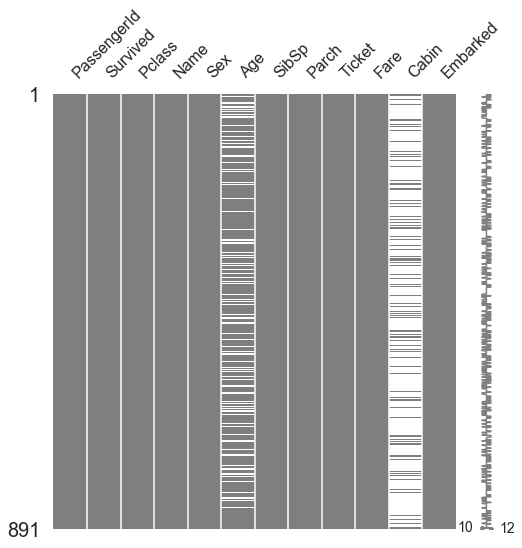

In [10]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8,8), color=(0.5, 0.5, 0.5))
# missingno.matrix : matrix(행렬) 형태로 누락데이터를 시각화 명령. 맨오른쪽은 스파크라인, 각 행의 데이터 완성도를 표현
# 흰색 칸이 결측치라고 보면 됨.
# iloc 은 i : index () 인덱스의 '위치' 기준으로 동작(only 정수)(행 번호) -> df.iloc 하면 인덱스 (0,1) 2개가 나옴.  
# loc 은 index가 가지고 있는 '값'을 기준으로 동작 -> df.loc[:2, :] 하면 인덱스에 2가 나오기 전까지 모든 값 나옴.
# ix 는 loc 처럼 작동하지만 index 값이 없으면 iloc 처럼 동작

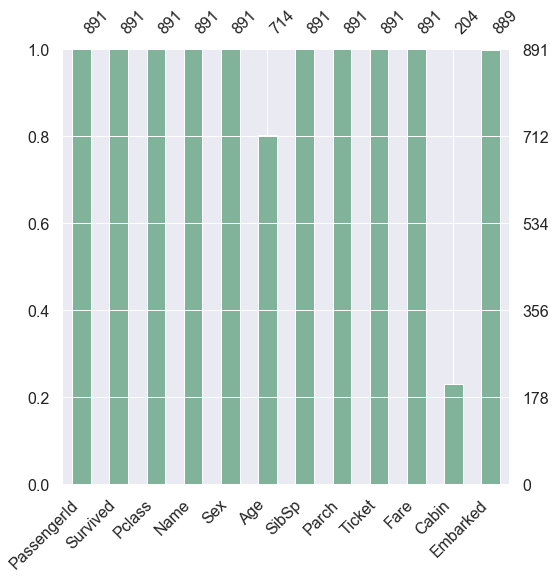

In [13]:
# 막대모형으로 만들기 missingno 만들기
msno.bar(df_train.iloc[:,:], figsize=(8,8), color=(0.5, 0.7, 0.6))
# 각 열에 누락된 데이터가 얼마나 존재하는지에 대해서 막대 시각화

### 결측치 시각화 방법
1. sns.heatmap(df.isnull(), cbar=False) -> cbar = True 하면 
2. missingno.matrix(data, figsize=(,), color=()) -> figsize 는 원하는 크기, color 는 색상 (1번이랑 비슷하게 나옴.)
3. missingno.bar(data)
4. missingno.heatmap(data)
5. missingno.dendrogram(data)

## Target label 확인 -> 우리의 타겟 라벨은 생존 Survived

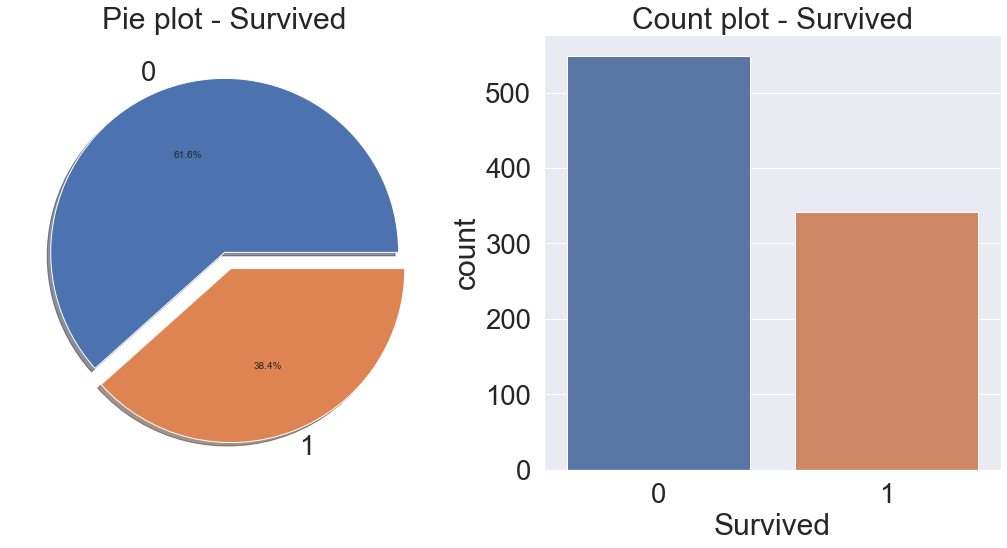

In [14]:
# target label 이 어떤 분포를 가지고 있는지 확인해야한다. 지금처럼 이진분류일때는 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있음
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
# plot.pie() 안에 explode=[,] 영역이 얼마나 떨어져있을지 표시. 클수록 멀리 떨어짐.
# autopct : 원 안에 어떤 글씨가 들어올지 -> 크기 확대는 어떻게 하는지 찾아야함.
# plot. : 뒤에 어떤 게 붙냐에 따라서 그래프가 달라짐.
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

# 0이 죽은사람, 1이 생존한 사람.
# 타겟 라벨의 분포가 제법 균일함. 60:40 정도로 만약 너무 불균일한 경우 예를 들어 100개 중 1이 10개 0이 90개면 
# 모델이 0으로만 전부 분류해도 90% 정확도를 갖게됨. 그러면 1을 찾는 모델을 만들었을 때 원하는 결과 얻을 수 없음
# 지금은 그렇지 않으니 계속 진행, 하지만 밸런스가 안맞는다면 맞게 하기 위한 방법을 고려해야함.

## Data EDA
1. 데이터는 매우 많음. 데이터 안에 숨겨진 사실(insight)을 찾기 위해서는 적절한 시각화가 필요
2. 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있음. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하기
3. 이진분류에는 이런 Plot 들을 사용하는구나, 이런 plot 은 어떤 것을 알아보고 싶을 때 사용하는구나 --> 이런 것들을 생각하고 기억하면서 공부를 해야함

In [16]:
# Pclass 에 대해서 살펴보기
# Pclass는 티켓 클래스 즉, 티켓 종류를 말함. 1은 1등석, 2는 2등석, 3은 3등석
# Pclass에 따른 생존률 차이 살펴보기. 엑셀의 피벗 차트와 유사한 작업 - pandas groupby 쓰거나 pivot 이라는 메소드도 있음
# Pclass 와 Survived 가져온 후 pclass로 묶음. 그러면 pclass마다 0, 1이 카운트됨
# sum을 하면 생존한 사람 1의 총합을 주게 됨.
# as_index : groupby 로 쓴 열을 인덱스로 만들거냐 안만들거냐? True 만든다 / False 안만든다

# Pclass 별 인원수
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [17]:
# Pclass 에서 Survived 항목의 합(sum) 0과 1로 구성되어 있기 때문에 sum 을 하면 1만 더해져서 결국 생존자의 수가 계산됨. 
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


In [29]:
# pandas 의 crosstab을 사용하면 위 과정을 더 수월하게 볼 수 있음.
pd.crosstab(index=df_train.Pclass, columns=df_train['Survived'],
            margins=True).style.background_gradient(cmap='summer_r')
# margins 가 True 이면 add row/column margins = all (합계)이 추가됨.
# 뒤에 style.background_gradient() 들어가면 배경에 색이 들어감.
# 첫번째 파라메타(index)가 기준, 두번째(columns)가 빈도를 구하고 싶은 column
# df_train['colunm'] 이나 df_train.colunm 이나 동일
# crosstab 에는 index 와 columns 항목이 온다.

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


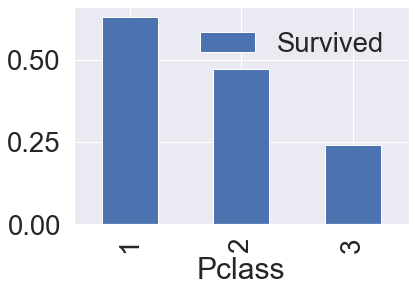

In [18]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], 
                                         as_index=True).mean().sort_values(by='Survived', 
                                                                           ascending=False).plot.bar()
# as_index : 그룹화 시킨 요소를 index 로 만들 것인가 default 는 True
# sort_values 는 열의 값에 따라서 sorting 하는 함수. by='기준 column', ascending : 내림차순/오름차순
# pclass가 높을수록 생존률이 높은 것을 확인할 수 있음.

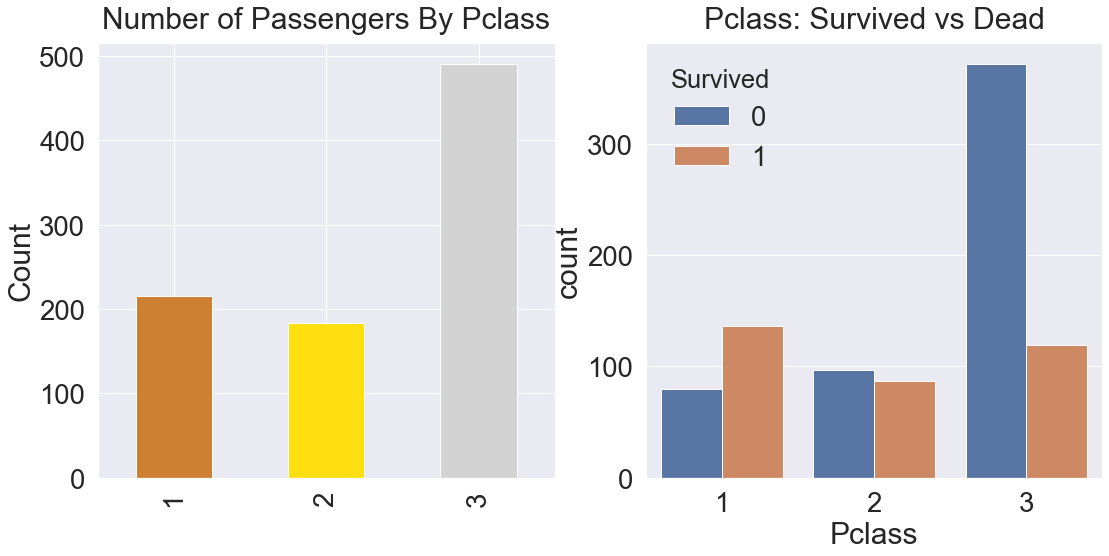

In [19]:
y_position=1.02
f, ax=plt.subplots(1,2, figsize=(18,8))
df_train['Pclass'].value_counts(sort=False).plot.bar(color=['#CD7F32','#FFDF10','#D3D3D3'], ax=ax[0])
# color CD는 황색, FFD 는 노란색, D3D 는 회색
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')

sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

# set_title 에서 y 값은 제목의 y축 위치를 말함. 제목과 그래프가 얼마나 떨어져있을지를 나타냄. 클수록 멀리 떨어지게 됨.
# 1번 그래프에 1, 2, 3 순서로 나오게 하고 싶으면? sort_values()는 안먹힌다. -> value_counts 안에 sort를 False로 해주면된다. 디폴트는 True
# 클래스가 높을수록 생존확률이 높음.

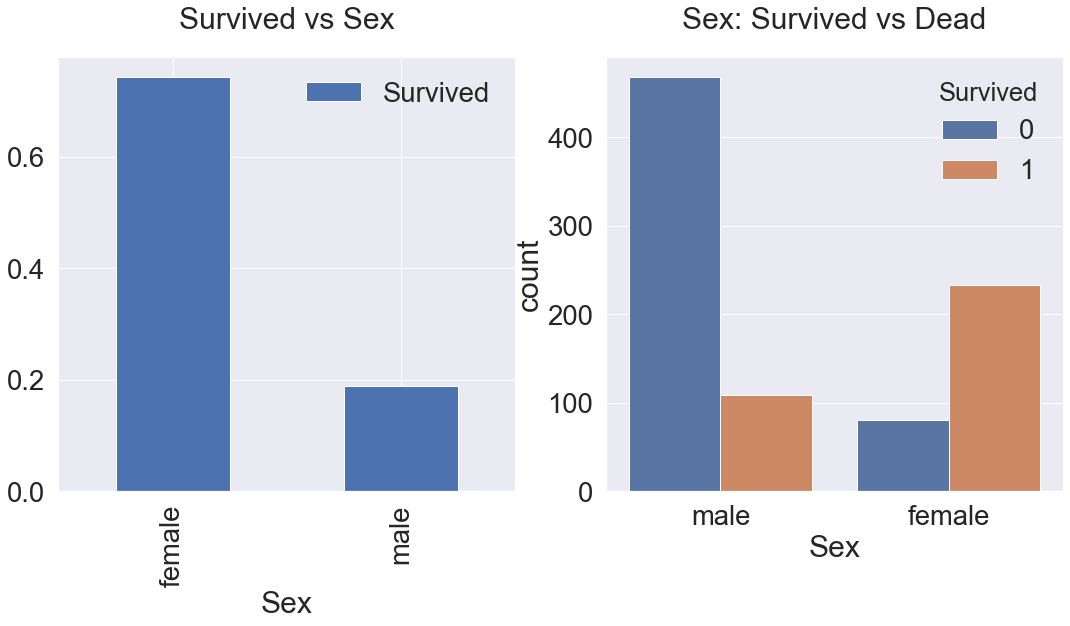

In [20]:
# 성별에 따른 생존률 차이 알아보기
f, ax=plt.subplots(1,2, figsize=(18,8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex', y=1.05)

sns.countplot('Sex', data=df_train, hue='Survived', ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead', y=1.05)
plt.show()
# groupby의 as_index : return object with group labels as the index 그룹 라벨을 인덱스로 쓴다.  이거 안하면 female male 아니라 0, 1로 나옴
# 여성이 생존할 확률이 더 높다. 

In [21]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# as_index 하면 male, female 이 index로 설정됨. default True

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [26]:
# cmap 에 따라서 색상이 바뀌는데, 자주 쓰는 색상을 설정해두고 사용하면 좋다. 
pd.crosstab(index=df_train['Sex'], columns=df_train['Survived'], margins=True).style.background_gradient(cmap='cubehelix_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


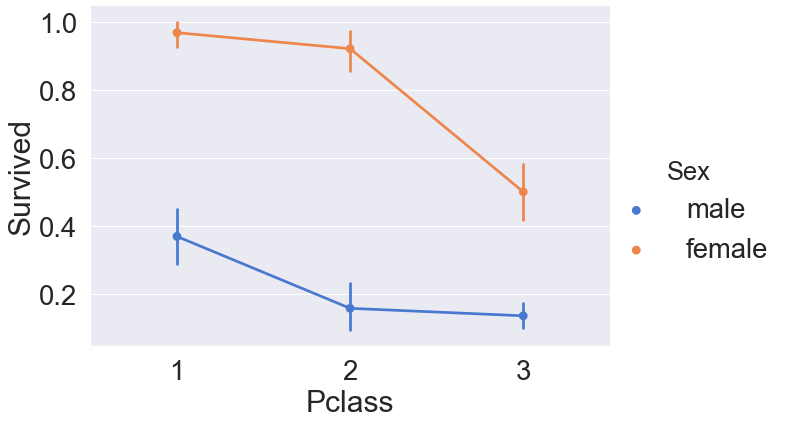

In [27]:
# Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는지 확인
# seaborn 의 factor plot 이용하면 3개의 차원으로 이루어진 그래프 그리기 쉬움.
sns.factorplot(x='Pclass', y='Survived', data=df_train, 
               hue='Sex', size=6, aspect=1.5, palette='muted')

# 여성이 남성보다 모든 클래스에서 더 생존 확률이 높음. 남녀 모두 클래스 높을수록 생존률 높음.    
# aspect : 그래프 크기의 width 너비를 의미.
# kind 나 color, palette 가능. color 랑 palette 랑 차이가 있음.
# color 는 전체 색상 컨셉? 같은 느낌이고 palette 는 hue 에 뭘 다르게 할지.

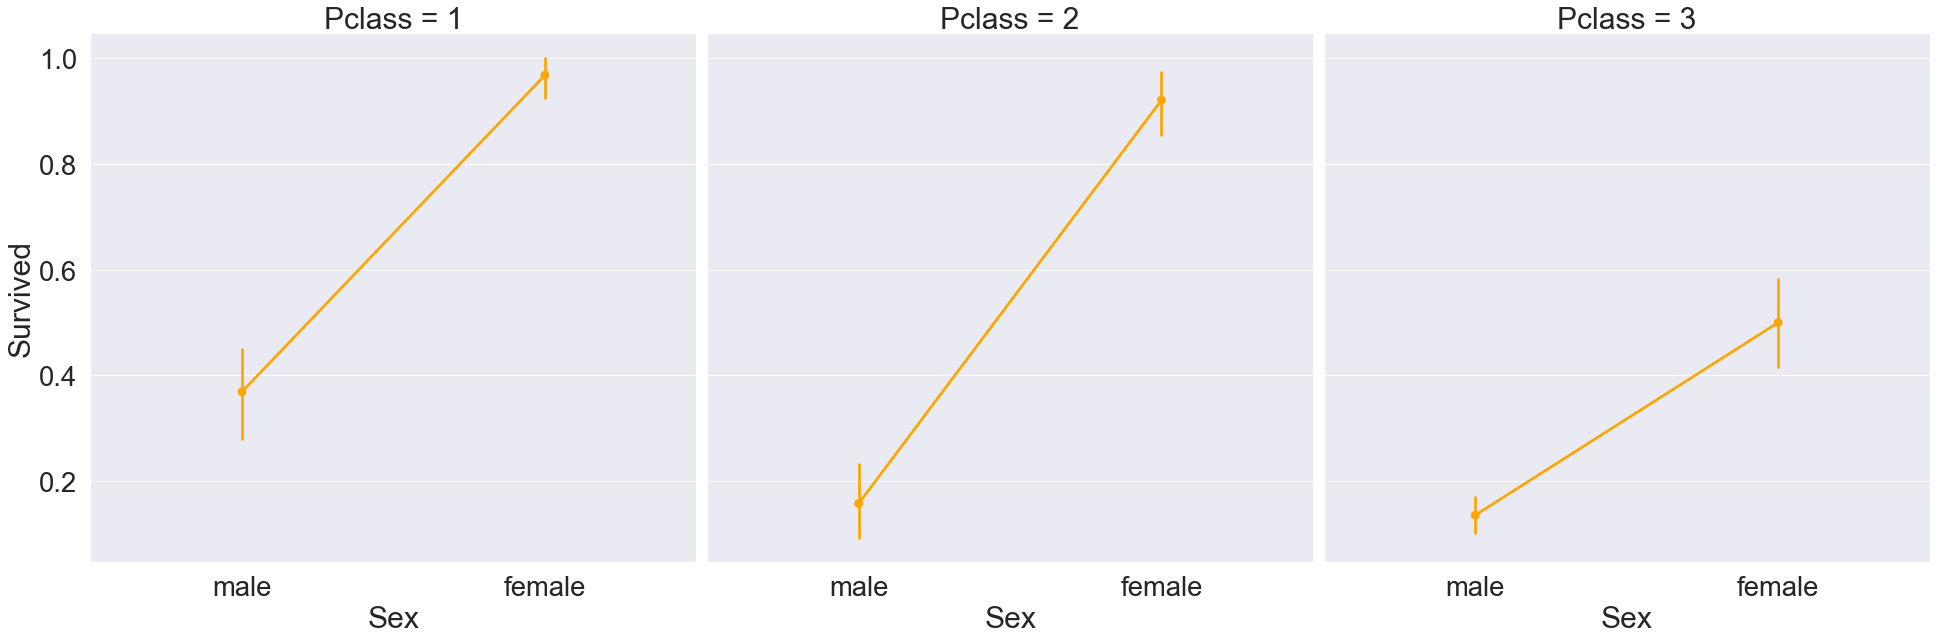

In [34]:
# hue 를 사용하지 않고 그냥 column 사용했을 경우 (2차원)
sns.factorplot(x='Sex', y= 'Survived', col='Pclass', 
              data=df_train, satureation=.5, size=9, aspect=1, color='orange')
# hue와 column 의 기능 차이 명확하게 알고 있기
# hue 는 하나의 그림에서 범주 나누기
# column 은 그래프를 '열' 처럼 나눠서 그림
# color 는 없었는데 추가. -> color 는 입력 가능. 전체 다 바뀌니까, 대신 palette 는 hue 에 따라 다른 색을 칠해주기 때문에 여기서는 hue 를 쓰지 않아서 palette 를 사용할 수가 없음. 

In [35]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))
# 정규표현식 공부 필요

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


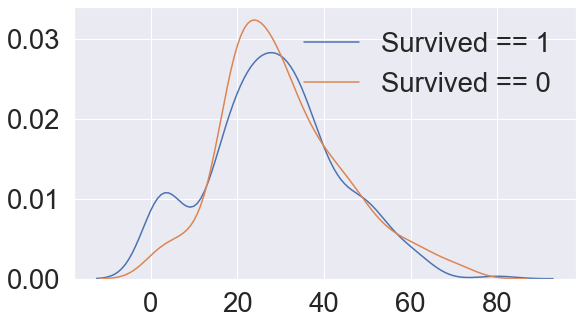

In [68]:
# seaborn 라이브러리의 kdeplot 은 밀도함수를 그릴 수 있는 함수
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0']) # legend 갯수 파악하고 리스트에 순서대로 적어주면 나옴. 
plt.show()
# df[df[]] : df 안에 df 또 사용하는 것은 데이터 안에 특정 열의 특정 값을 찾으려고 할 때 사용
# 한 화면에 여러 그래프를 그리고 싶으면 그래프를 여러개 그리고 ax 를 동일한 곳에 설정하면 된다. 

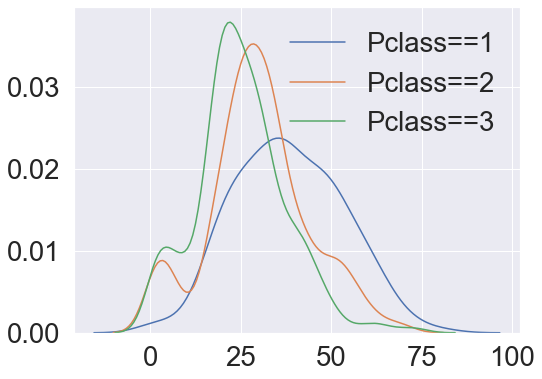

In [71]:
# 위에 그래프 참고해서 그린 것. 아래랑 그래프는 똑같음. 그냥 그리는 방법을 여러개 보여주려고 한듯. 
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.kdeplot(df_train[df_train['Pclass'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Pclass'] == 2]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Pclass'] == 3]['Age'], ax=ax)
plt.legend(['Pclass==1', 'Pclass==2', 'Pclass==3'])
plt.show()

# 이건 seaborn 에서 제공하는 kdeplot 함수 사용

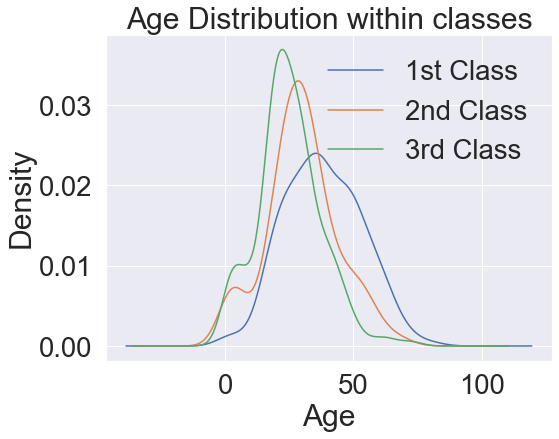

In [71]:
# Age distribution withing clases
# pandas.DataFrame 라이브러리 에서 제공하는 plot 함수 / seaborn 이랑 사용법이 다르다.
# pandas.DataFrame.plot() -> kind 파라메타에는 line/bar/barth/hist/box/kde/density/area/pie/scatter/hexbin 이 있음.
plt.figure(figsize=(8,6))
df_train['Age'][df_train['Pclass']==1].plot(kind='kde') # kind를 바꾸면 원하는 종류의 그래프를 그릴 수 있음.
df_train['Age'][df_train['Pclass']==2].plot(kind='kde')
df_train['Age'][df_train['Pclass']==3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])
# 클래스가 높아질수록 연령대가 높아짐.
# kde plot 을 그리는 방법은 위에도 있고 아래 방법도 있다.

1. class 가 높을 수록 나이 많은 사람 비중이 많음
2. 나이대가 변하면서 생존률이 어떤지
3. 나이 버뮈를 넓혀가며 생존률이 어떻게 변화 되는지 관찰

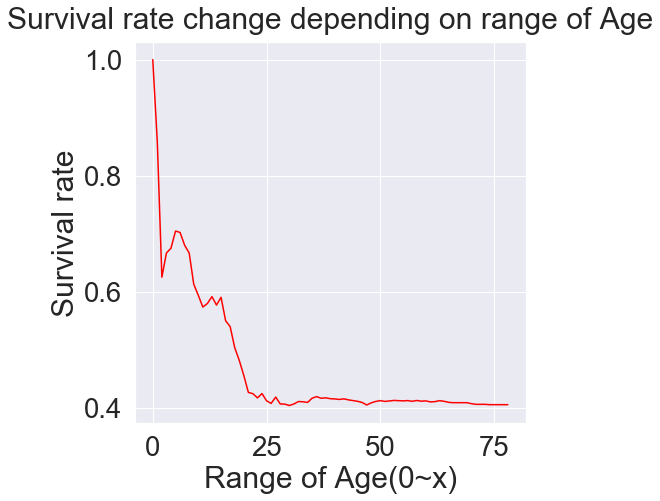

In [36]:
# 나이대에 다른 생존률의 변화
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age']<i]['Survived'].sum()/
                                   len(df_train[df_train['Age']<i]['Survived']))

plt.figure(figsize=(7,7))
plt.plot(cummulate_survival_ratio, color='red')
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.xlabel('Range of Age(0~x)')
plt.ylabel('Survival rate')
plt.show()

# 나이가 0세부터 해서 80세까지 각 나이마다 생존 확률값을 찍으려면 80개가 되야하니까 효율을 위해 반복 필요 -> for문 
# list 에 나이 별 생존률을 계산해서 입력. sum 해서 1의 개수 모두 더하고 그 길이로 나눠서 계산
# 0~1 0~3 0~70 이렇게 계속 구간이 늘어가는 것. 총 38.% 나오니까 결국 최종이 0.4 근처까지 나옴. (데이터 전체의 생존률이 38.% 이니까)

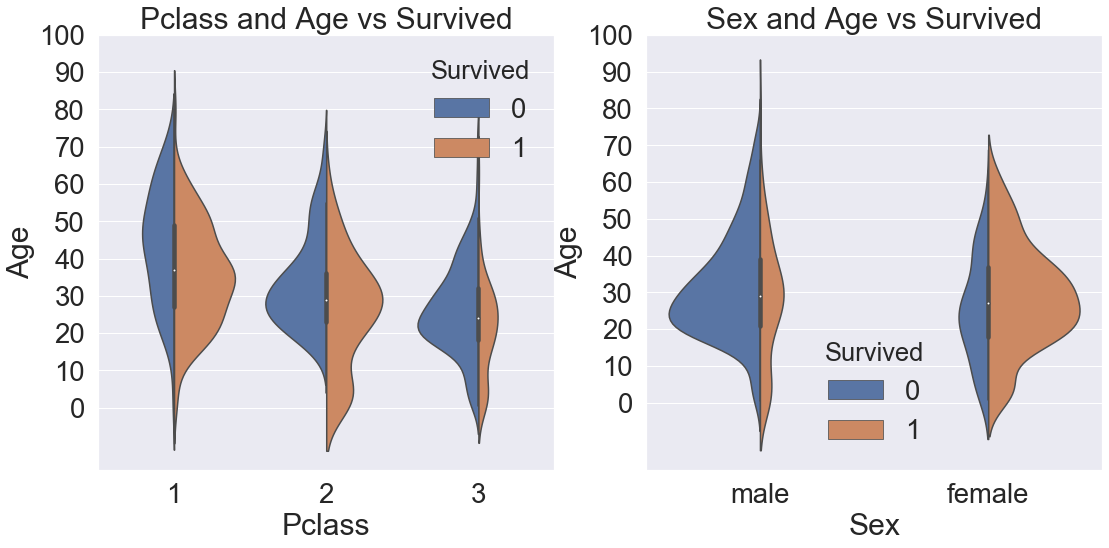

In [37]:
f, ax = plt.subplots(1,2, figsize=(18, 8))
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df_train, scale='count', 
              split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot('Sex', 'Age', hue='Survived', data=df_train, scale='count', 
              split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110, 10))
plt.show()
# violinplot 의 scale 은 크기를 어떻게 할지 count로 하면 갯수에 비례해서 나타내겠다.
# 이진분류인데 3차원을 알고 싶을 때 사용. 바이올린 -> 분포를 나타냄. 분포를 비교하고 싶을 때 사용 kdeplot 에 응용버전?
# violin plot 은 x축은 범주형, y축은 연속형이 들어가줘야함. 그래야 y축에 분포가 나타나니까

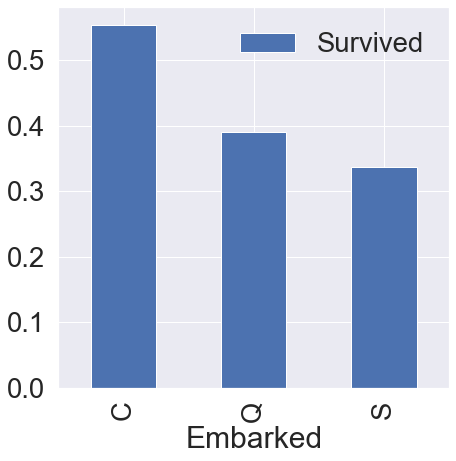

In [40]:
# Embarked - 탑승한 항구
f, ax = plt.subplots(1,1, figsize=(7,7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot(kind='bar', ax=ax)
# 그리 중요한 변수를 아니지만 일단 사용. 모델을 만들고나면 사용한 변수가 얼마나 중요한 역할을 했는지도 볼 수 있음. 

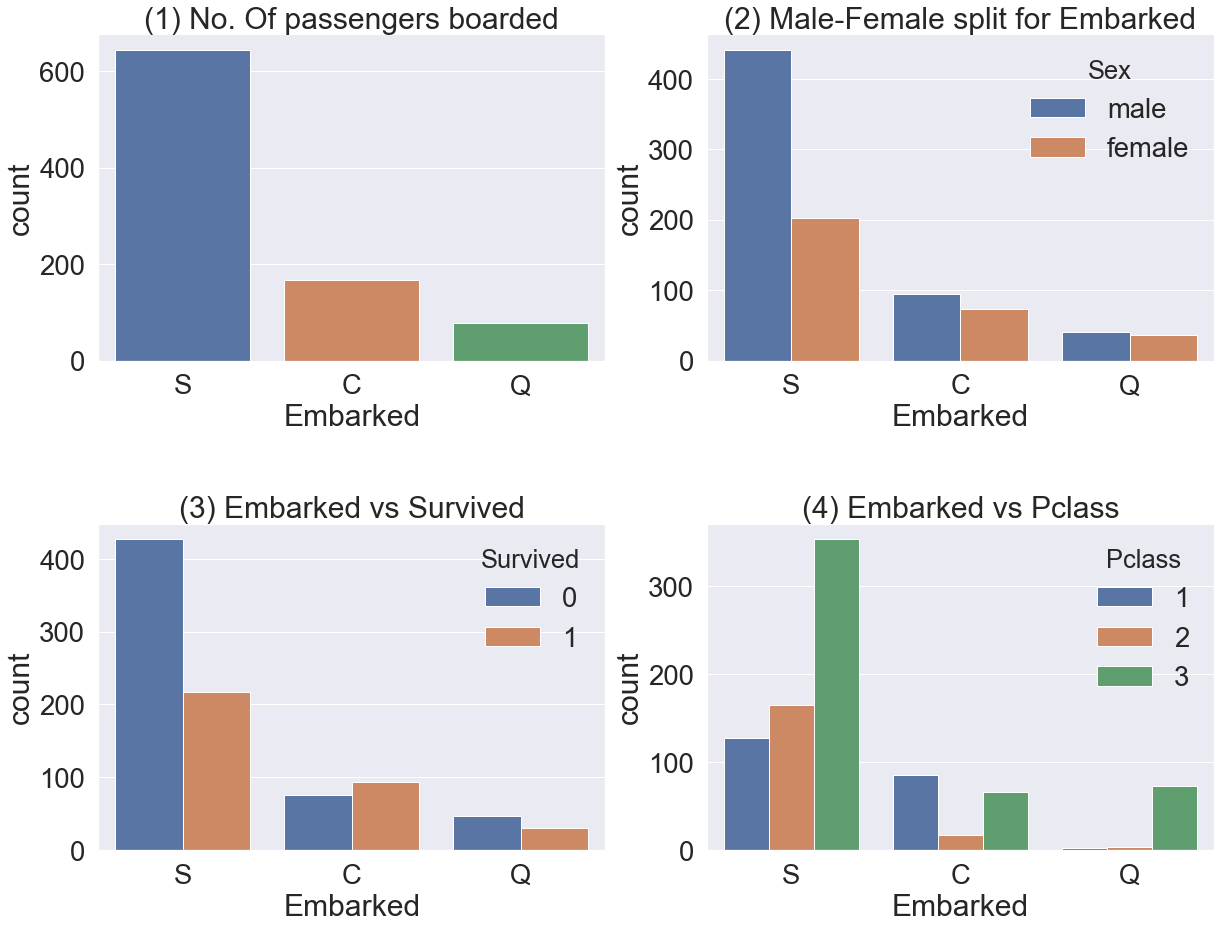

In [41]:
f, ax=plt.subplots(2,2, figsize=(20,15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of passengers boarded')
sns.countplot('Embarked', data=df_train, hue='Sex', ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female split for Embarked')
sns.countplot('Embarked', data=df_train, hue='Survived', ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', data=df_train, hue='Pclass', ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# show the counts of observations in each categorical bin using bars.

In [42]:
# SibSp(형제 자매), Parch(부모, 자녀) -> 둘을 합치면 가족이 될 것 Family
df_train['FamilySize']=df_train['SibSp']+df_train['Parch']+1 # 자기 자신 포함 +1
df_test['FamilySize']=df_test['SibSp']+df_test['Parch']+1

In [43]:
print('Maximum size of Family:',df_train['FamilySize'].max())
print('Minimum size of Family:',df_train['FamilySize'].min())

Maximum size of Family: 11
Minimum size of Family: 1


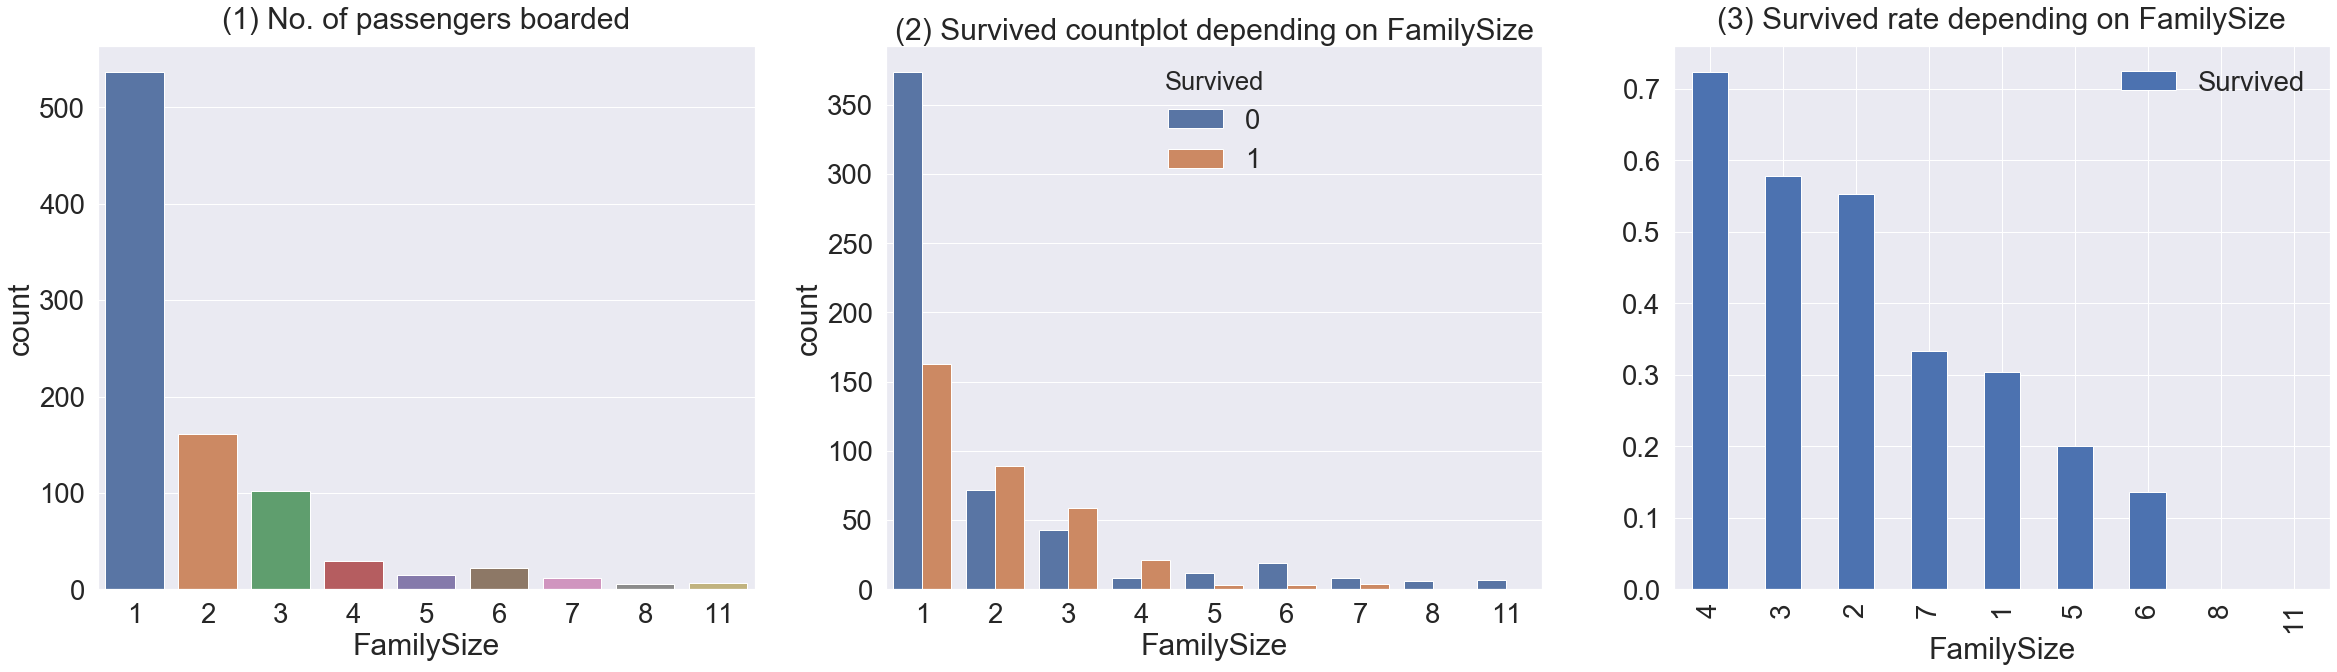

In [44]:
f, ax = plt.subplots(1, 3, figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. of passengers boarded', y=1.02)

sns.countplot('FamilySize', data=df_train, hue='Survived', ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize')

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', 
                                                                                              ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5) # tune the subplot layout 레이아웃 조절. width, height 간격?
plt.show()

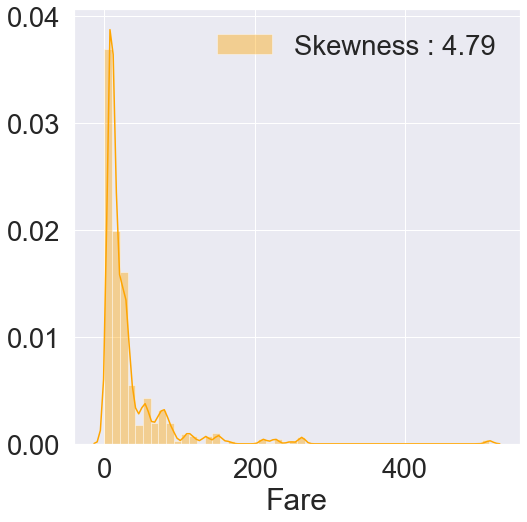

In [46]:
# fare 탑승요금 - 연속형 수치
fig, ax=plt.subplots(1,1, figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='orange', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best') #  loc는 범례의 위치에 관련된 파라메타. best는 가장 좋은 위치. 그 외에 'upper left', 'upper right', 'lower left', 'lower right' 가 있음.
# 여기서 label 은 x축 y축 라벨이 아님. 
# distplot Flexibly plot a univariate distribution of observations.
# combines the matplotlib histogram function with the seaborn kdeplot() and ugplot()

In [47]:
# 분포가 매우 비대칭적. 이대로 모델에 넣어주면 잘못 학습할수도 있음. 몇개 없는 outlier에 민감하게 반응하면 실제 예측에 좋지 않은 결과를 도출할 수 있음.
# outlier 영향을 줄이기 위해서 데이터에 log 스케일링을 진행.
# map 과 apply 둘 다 가능
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # test set에 있는 nan value 를 평균값으로 치환

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].apply(lambda i: np.log(i) if i > 0 else 0)

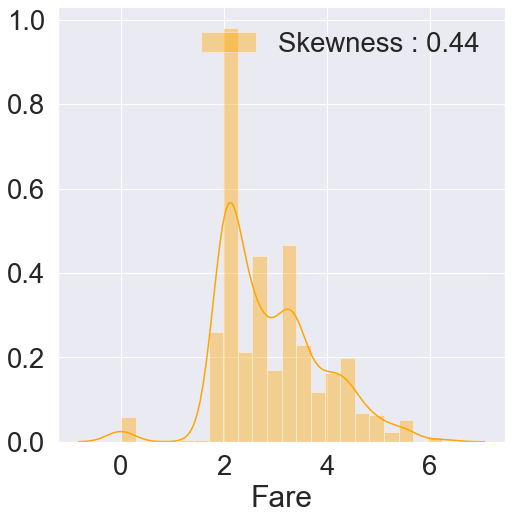

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='orange', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')
# 로그 스케일링을 했더니 분포가 어느정도 대칭적으로 되었음.
# 모델이 좀 더 좋은 성능을 내도록 할 수 있음. 
# feature engineering 에 들어가는 부분임. 

##### Cabin 객실은 결측치가 많고 생존 예측에는 중요한 정보 얻기 힘들기 때문에 제외
##### 하지만 객실 정보와 객실 위치, 구조 보트와의 거리, 바다로부터 객실의 거리 등이 있다면 유의미하게 사용될수도 있을 것.

### 티켓은 알아서 해보기

## Feature engineering
1. dataset 에 존재하는 null data 채우기
2. null data를 포함하는 feature statistics를 참고하거나 다른 아이디어를 짜내어 채울 수 있음.
3. null data 에 따라 모델의 성능이 달라질 수 있음. 
4. Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로 train 뿐 아니라 test 에도 동일하게 적용해주어야 한다.

In [49]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
dtype: int64

In [50]:
# fill null
# age 에 null data 가 177개 존재. cabin 697개 존재. embarked 2개 존재
# 영어 이름에 Miss, Mrr, Mrs 같은 title 이용하겠음.
# pandas series 에는 data 를 string 으로 바꿔주는 str (method), 거기에 정규표현식을 적용하게 해주는 extract (method)가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다
df_train['Initial']=df_train.Name.str.extract('([A-Za-z]+)\.') # Lets extract the salutations
df_test['Initial']=df_test.Name.str.extract('([A-Za-z]+)\.') # Lets extract the salutations
# 정규표현식 + \ . 용도?

In [51]:
df_train['Initial']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Initial, Length: 891, dtype: object

In [55]:
pd.crosstab(df_train['Sex'], df_train['Initial']).style.background_gradient(cmap='gist_heat')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [56]:
df_train['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess',
                            'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'], 
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other',
                           'Other','Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)
df_test['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess',
                            'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'], 
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other',
                           'Other', 'Other','Mr', 'Mr', 'Mr', 'Mr'], inplace=True)
# 명확하게 분류를 진행해서 범주 종류를 줄임.
# inplace = True : 다른 객체를 반환하지 않고 기존 객체를 수정 / False

In [57]:
df_train.groupby('Initial').mean()
# 5 가지로 범주를 축소시킨 후 생존률과 연관이 있는지 확인
# 우리가 주목해야할 사항이 생존률이기 때문에 어떤 것이 관련이 있을지 계속 생각을 하면서 할 수 있는 분석을 진행.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


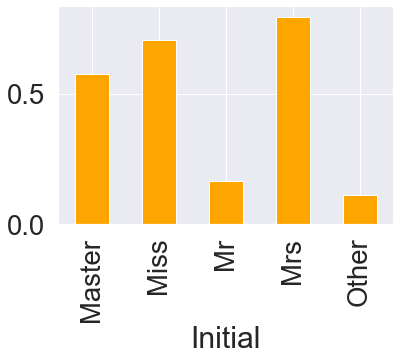

In [60]:
df_train.groupby('Initial')['Survived'].mean().plot.bar(color='orange')

In [61]:
# Initial 카테고리 별 Age의 평균을 이용하여 Null을 채우기로 함. (커널 마다 다양한 방식 사용)   
# 아까 만든 이니셜에 따른 평균 연령을 넣어주기로 함. 이니셜은 5개로 정의를 했었음.
# 물론 다른 방법도 존재함. 머신러닝 알고리즘을 사용해서도 채울 수 있음.
# loc + boolean + column 이용
# loc 와 iloc 차이점
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

#### loc : 인덱스 기준으로 행 데이터 읽기 - 상대적, 중간에 삭제되면 변할수도
#### iloc : 행 번호를 기준으로 행 데이터 읽기 - 절대적, 불변 0~

In [62]:
print('Embarked has ', df_train['Embarked'].isnull().sum(), ' Null Values')
# 깔끔하게 표현되긴 함. 근데 info() 쓰면 전체 다 파악 가능
# sum(df_train['Embarked'].isnull()) 이랑 같음. 가운데는

Embarked has  2  Null Values


In [63]:
df_train['Embarked'].fillna('S', inplace=True)
# 가장 많은 S로 그냥 다 채워줌. -> 결측치 채우는 방법은 다양하니까 상황에 맞게 분석가 판단하에 설정 

In [64]:
# Age - 연속형 숫자 => 카테고리형으로 (정보 누락이 발생할 수 있는 위험성 있음)
# 첫 번째 방법 , 나이를 10살 간격으로 나누기
df_train['Age_cat'] = 0
df_train.loc[df_train['Age']<10, 'Age_cat'] = 0
df_train.loc[(df_train['Age'] >=10) & (df_train['Age']<20), 'Age_cat'] = 1
df_train.loc[(df_train['Age'] >=20) & (df_train['Age']<30), 'Age_cat'] = 2
df_train.loc[(df_train['Age'] >=30) & (df_train['Age']<40), 'Age_cat'] = 3
df_train.loc[(df_train['Age'] >=40) & (df_train['Age']<50), 'Age_cat'] = 4
df_train.loc[(df_train['Age'] >=50) & (df_train['Age']<60), 'Age_cat'] = 5
df_train.loc[(df_train['Age'] >=60) & (df_train['Age']<70), 'Age_cat'] = 6
df_train.loc[(df_train['Age'] >=70), 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age']<10, 'Age_cat'] = 0
df_test.loc[(df_test['Age'] >=10) & (df_test['Age']<20), 'Age_cat'] = 1
df_test.loc[(df_test['Age'] >=20) & (df_test['Age']<30), 'Age_cat'] = 2
df_test.loc[(df_test['Age'] >=30) & (df_test['Age']<40), 'Age_cat'] = 3
df_test.loc[(df_test['Age'] >=40) & (df_test['Age']<50), 'Age_cat'] = 4
df_test.loc[(df_test['Age'] >=50) & (df_test['Age']<60), 'Age_cat'] = 5
df_test.loc[(df_test['Age'] >=60) & (df_test['Age']<70), 'Age_cat'] = 6
df_test.loc[(df_test['Age'] >=70), 'Age_cat'] = 7

In [65]:
# 두 번째 방법
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)
# apply : 만들어진 함수를 적용

In [66]:
# 두 방법이 모두 같은 결과를 내었는지 확인
print('1번, 2번 모든 값이 같으면 True 하나라도 다르면 False ->', (df_train['Age_cat'] == df_train['Age_cat_2']).all())
# 같아야 하는데 다르게 나오는...?

1번, 2번 모든 값이 같으면 True 하나라도 다르면 False -> True


In [67]:
# 필요없는 열 삭제
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

카테고리들을 컴퓨터가 인식할 수 있게 수치화를 시켜줘야한다.
map method 이용하여 간단하게 가능.

In [68]:
df_train['Initial']=df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 
                                           'Other':4})
df_test['Initial']=df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 
                                           'Other':4})

In [69]:
# 숫자형 카테고리로 잘 변했는지 확인.
# dataframe.unique() : 특정 열에 속하는 변수들을 중복 없이 알려줌.
df_train['Initial'].unique()
# 컴퓨터가 인식하도록 잘 정리.

array([2, 3, 1, 0, 4], dtype=int64)

In [70]:
# value_counts() : 열에 속하는 각 변수들의 개수(인스턴스 수)를 알려줌.
df_train.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [71]:
df_train['Embarked']=df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked']=df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [72]:
df_train['Embarked'].unique()

array([2, 0, 1], dtype=int64)

In [73]:
df_train['Embarked'].isnull().any()
# null 이 하나라도 있을 시 true 가 나옴.

False

In [74]:
df_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [75]:
df_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [76]:
df_train['Sex']=df_train['Sex'].map({'male':1, 'female':0})
df_test['Sex']=df_test['Sex'].map({'male':1, 'female':0})

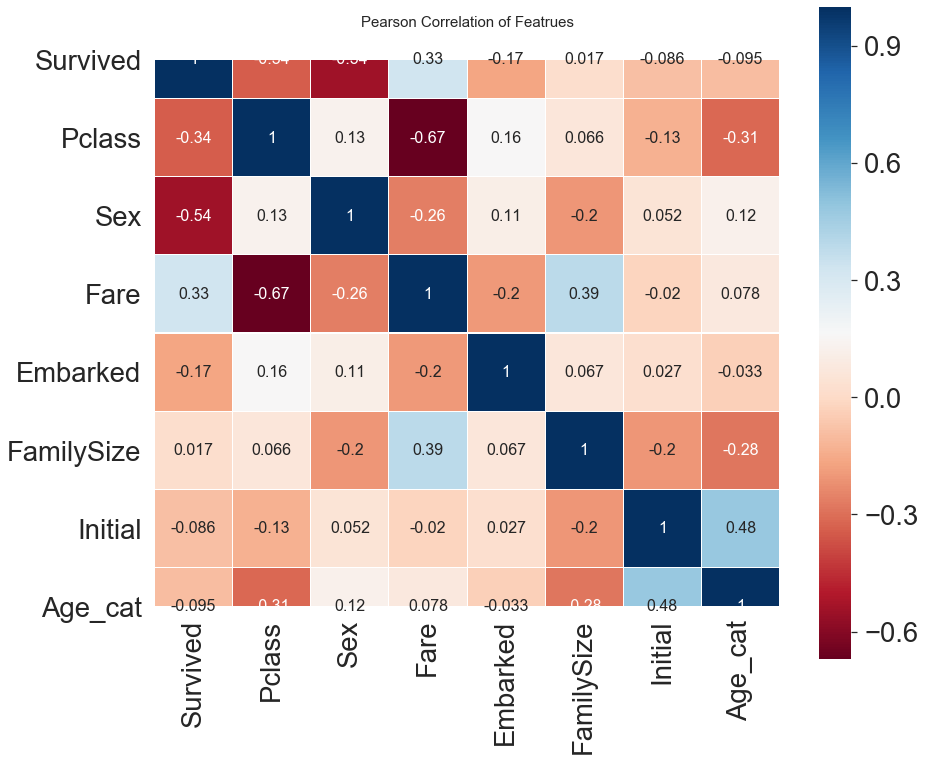

In [78]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize',
                        'Initial', 'Age_cat']]
color_map = plt.cm.RdBu

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Featrues', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=color_map, linecolor='white', annot=True, annot_kws={'size':16})

del heatmap_data
# 히트맵 그리는 다른 더 간단한 방법도 있음.
# linewidths : width of the lines that will divide each cell
# vamx : Values to anchor the colormap, otherwise they are inferred from the data and other keyword arguments
# 색상 관련된 기준 같은 것.
# annot : If True, write the data value in each cell.

생존률과 성별, 티켓 등급, 운임요금이 상관관계를 가진다는 것을 알 수 있었음.
서로 강한 상관관계를 가지는 feature 들도 없었음.
우리가 모델을 학습시킬 때 불필요한 feature 가 없다는 것을 의미함.

## One-hot encoding
모델 학습을 위한 data preprocessing 전처리
성능이 향상된다. 수치화랑은 조금 다름. pandas의 get_dummies 를 이용하여 쉽게 해결
One-hot encoding 은 (0, 1) 로 이루어진 다차원의 벡터로 나타내는 것을 말합니다.

In [79]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='initial')
# prefix 데이터 프레임 열 이름을 추가할 문자열

In [80]:
df_train.head()
# _1,2,3,4,5 로 더미 변수가 생성되었음

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [81]:
# Embarked 에도 적용
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [83]:
df_train.head(2)
# 생성된 것 확인 가능

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0


In [84]:
# 모델 제작에 있어서 불필요한 변수들 모두 삭제
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [85]:
df_train.head()
# 모델 구축에 사용할 변수만 남아있음. 

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [86]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,initial_0,initial_1,initial_2,initial_3,initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


# 전처리, EDA, Feature engineering 종료. -> 머신러닝 구현

In [87]:
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 모델을 사용할 것
from sklearn import metrics # 모델의 평가를 위해서 사용
from sklearn.model_selection import train_test_split # train / test 를 쉽게 나눠주는 함수
# sklearn 에는 모든 머신러닝 파이프 라인이 다 들어있음. 책으로 공부하기 (보라색)

In [88]:
# preparation - split dataset into train, valid, test
# 가장 먼저 Survived 분리. drop 을 사용해서 간단하게
X_train = df_train.drop('Survived', axis=1).values
target_label=df_train['Survived'].values
X_test = df_test.values

In [108]:
# train_test_split 으로 train test 로 분리
X_tr, X_vld, y_tr, y_vld =train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

In [109]:
# 랜덤포레스트 사용. 결정트리 기반 모델이며 여러 결정 트리들을 앙상블한 모델. 
# 파라미터들을 어떻게 조정하느냐에 따라서 성능이 달라짐. 
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [110]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))
# 안에 metrics가 어떻게 생겼는지. 그중에 정확도는 뭔지 shape[0]은 뭔지 또 알아야함.

총 268명 중 81.34% 정확도로 생존을 맞춤


### Feature importance
어느 변수가 영향을 많이 미쳤는지

In [111]:
from pandas import Series
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

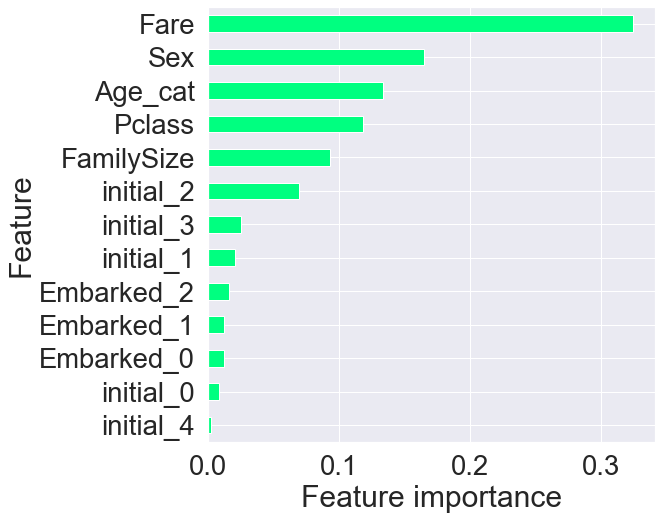

In [117]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot(kind='barh', cmap='winter_r')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

# dataframe.plot() 는 palette 가 없음. 대신 color 나 cmap 사용

### 제출하기

In [118]:
submission = pd.read_csv('./input/gender_submission.csv')

In [119]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [120]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [ ]:
# 데이터 프레임을 csv 형식으로 저장해주기
submission.to_csv('./my_first_submission.csv', index=False)